Mi proyecto final se basa en la optimización de un portafolios de inversión, basado en la metodología de Markowitz.
Para esto, elegí todas las acciones del S&P500 y del Nasdaq.
Como primer paso, necesito agruparlas por clústers que representen la mayor correlación de los rendimientos diarios. De ésta manera, podré elegir acciones de los diferentes cluster que no presenten una correlación significativa entre ellas, para que el portafolio final de inversión, sea lo más diversificado posible.

In [393]:
import numpy as np # Para datos numéricos en forma de matriz
import pandas as pd # Para datos en forma de tabla
import matplotlib.pyplot as plt # Para fines de visualización (gráficos).
import matplotlib.pylab as pl # Para fines de visualización (gráficos).
import requests
import yfinance as yf # Para descargar datos de precios de acciones
import random # Para generar números aleatorios
import pandas_datareader as pdr # Para descargar datos financieros

import csv # Para leer archivos
from datetime import datetime, timedelta #Para ajustar las fechas

from matplotlib.collections import LineCollection # Para fines de visualización (gráficos).
from sklearn import cluster, covariance, manifold # Para análisis gráfico

from scipy.stats import norm # Scipy.stats contiene funciones estadísticas y probabilísticas, como la función de densidad de probabilidad y la función de distribución acumulada de la distribución normal (norm)
from scipy.optimize import minimize #La función "minimize" se utiliza para minimizar una función de una o varias variables, utilizando diversos métodos de optimización. Busca los valores de entrada de una función que minimicen su valor de salida

# Ignorar las advertencias que puedan aparecer
import warnings
warnings.filterwarnings('ignore')

In [394]:
nasdaq = pd.read_csv('archivo_NDQ.csv')
sp = pd.read_csv('archivo_S&P500.csv')

nasdaq['Date'] = pd.to_datetime(nasdaq['Date'])
nasdaq = nasdaq.set_index('Date')
sp['Date'] = pd.to_datetime(sp['Date'])
sp = sp.set_index('Date')

lista_df = [sp,nasdaq]

#Creo el data frame con todas las acciones del S&P500 y Nasdaq

In [395]:
#Como varias acciones cotizan en ambos índices, tengo que eliminar las columnas repetidas
columnas_comunes = nasdaq.columns.intersection(sp.columns)
sp_sin_columnas = sp.drop(columns=columnas_comunes)

df = pd.concat([nasdaq, sp_sin_columnas], axis=1)

In [396]:
df.head()

,AAPL,ABNB,ADBE,ADI,ADP,ADSK,AEP,AMAT,AMD,AMGN,...,WTW,WY,WYNN,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2014-03-24,16.961678,NaN,65.239998,43.131767,53.917656,49.740002,34.144585,17.563068,4.05,91.916870,...,94.569939,19.563759,190.783356,61.421062,41.524548,31.381226,44.300667,82.525970,70.190002,27.129314
2014-03-25,17.144127,NaN,65.809998,42.874317,54.079857,49.779999,34.571739,17.790255,4.05,91.424225,...,95.929543,19.577145,186.708939,61.596313,41.911003,32.180920,43.854858,83.350677,70.449997,27.241039
2014-03-26,16.980236,NaN,63.900002,42.439869,53.741337,48.680000,34.536728,17.353357,4.05,91.030106,...,94.725983,19.336193,182.770584,61.459991,41.898090,31.495464,44.086674,83.197937,68.790001,27.194481
2014-03-27,16.907251,NaN,64.529999,42.303082,54.072819,48.279999,34.872860,17.204823,3.91,92.682281,...,95.623810,19.302738,181.826370,62.459457,41.658512,31.442745,43.510117,83.350700,68.709999,27.278276
2014-03-28,16.888374,NaN,64.879997,42.512260,54.270302,48.340000,35.012913,17.632971,3.88,91.363586,...,95.915619,19.530291,185.016174,63.407009,41.916531,31.636070,44.104507,84.204338,68.709999,27.008287


In [397]:
df.describe()

,AAPL,ABNB,ADBE,ADI,ADP,ADSK,AEP,AMAT,AMD,AMGN,...,WTW,WY,WYNN,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZTS
count,2517.000000,824.000000,2517.000000,2517.000000,2517.000000,2517.000000,2517.000000,2517.000000,2517.000000,2517.000000,...,2517.000000,2517.000000,2517.000000,2517.000000,2517.000000,2517.000000,2517.000000,2517.000000,2517.000000,2517.000000
mean,79.556786,140.048058,285.544263,102.790450,137.288265,153.699464,64.739373,65.102691,46.895137,175.197457,...,164.536684,25.893337,107.183390,64.687587,47.622106,70.036461,84.528614,115.234027,212.525633,107.065537
std,58.082184,28.154511,178.626176,48.354006,60.774467,79.877711,17.072428,46.664709,46.139119,51.385056,...,50.743896,4.979521,32.168194,19.751718,9.263330,28.738798,29.680653,17.437894,142.062825,58.008583
min,16.293823,82.489998,58.630001,35.176785,51.999344,42.639999,34.144585,12.925512,1.620000,83.959000,...,89.957626,11.533244,42.583988,25.646795,26.315708,27.261570,40.524632,75.934502,46.930000,26.440374
25%,28.261816,117.652502,102.309998,55.141830,76.295029,68.790001,49.508617,26.627333,6.760000,128.920959,...,112.738167,22.069632,84.769417,55.382545,40.300076,44.203236,55.863838,103.964836,88.309998,48.020966
50%,48.979881,140.004997,267.700012,91.364899,128.873199,149.960007,68.074532,47.833958,27.500000,164.432602,...,160.135712,24.984413,102.718285,59.640774,48.482422,70.182442,82.163879,112.947617,182.960007,94.838463
75%,139.433502,161.792496,438.880005,150.999329,194.959839,211.380005,78.836800,107.931435,84.639999,217.676224,...,207.985779,29.621929,126.546860,65.558624,55.373661,93.897926,111.891060,125.594864,280.720001,161.248260
max,197.857529,216.839996,688.369995,200.425552,261.121094,342.269989,98.984482,212.610001,211.380005,322.042450,...,277.570007,39.106037,193.479782,118.014030,66.734695,133.825974,140.740005,169.807602,614.549988,242.464081


In [398]:
df.shape

(2517, 519)

In [399]:
#Verifico que la columna Date ya no forme parte de las features
df.columns

Index(['AAPL', 'ABNB', 'ADBE', 'ADI', 'ADP', 'ADSK', 'AEP', 'AMAT', 'AMD',
       'AMGN',
       ...
       'WTW', 'WY', 'WYNN', 'XOM', 'XRAY', 'XYL', 'YUM', 'ZBH', 'ZBRA', 'ZTS'],
      dtype='object', length=519)

In [400]:
#Como parte de las buenas prácticas de DS, tengo que asegurarme que no queden GAPS de fechas entre las
#filas de datos
df = df.asfreq('D')
df

,AAPL,ABNB,ADBE,ADI,ADP,ADSK,AEP,AMAT,AMD,AMGN,...,WTW,WY,WYNN,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2014-03-24,16.961678,NaN,65.239998,43.131767,53.917656,49.740002,34.144585,17.563068,4.050000,91.916870,...,94.569939,19.563759,190.783356,61.421062,41.524548,31.381226,44.300667,82.525970,70.190002,27.129314
2014-03-25,17.144127,NaN,65.809998,42.874317,54.079857,49.779999,34.571739,17.790255,4.050000,91.424225,...,95.929543,19.577145,186.708939,61.596313,41.911003,32.180920,43.854858,83.350677,70.449997,27.241039
2014-03-26,16.980236,NaN,63.900002,42.439869,53.741337,48.680000,34.536728,17.353357,4.050000,91.030106,...,94.725983,19.336193,182.770584,61.459991,41.898090,31.495464,44.086674,83.197937,68.790001,27.194481
2014-03-27,16.907251,NaN,64.529999,42.303082,54.072819,48.279999,34.872860,17.204823,3.910000,92.682281,...,95.623810,19.302738,181.826370,62.459457,41.658512,31.442745,43.510117,83.350700,68.709999,27.278276
2014-03-28,16.888374,NaN,64.879997,42.512260,54.270302,48.340000,35.012913,17.632971,3.880000,91.363586,...,95.915619,19.530291,185.016174,63.407009,41.916531,31.636070,44.104507,84.204338,68.709999,27.008287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-18,173.720001,161.860001,513.859985,191.220001,241.850006,255.179993,82.160004,200.729996,190.649994,270.899994,...,273.820007,34.150002,98.839996,112.300003,32.980000,127.489998,136.270004,125.959999,285.970001,170.690002
2024-03-19,176.080002,161.789993,521.190002,190.539993,244.130005,256.190002,83.320000,201.339996,181.419998,271.730011,...,272.940002,34.529999,99.750000,113.089996,33.110001,128.449997,137.289993,126.660004,285.190002,172.960007


In [401]:
#Para completar los días que no tengo datos, utilizo los valores del día anterior
df.fillna(method='ffill', inplace=True)
df

,AAPL,ABNB,ADBE,ADI,ADP,ADSK,AEP,AMAT,AMD,AMGN,...,WTW,WY,WYNN,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2014-03-24,16.961678,NaN,65.239998,43.131767,53.917656,49.740002,34.144585,17.563068,4.050000,91.916870,...,94.569939,19.563759,190.783356,61.421062,41.524548,31.381226,44.300667,82.525970,70.190002,27.129314
2014-03-25,17.144127,NaN,65.809998,42.874317,54.079857,49.779999,34.571739,17.790255,4.050000,91.424225,...,95.929543,19.577145,186.708939,61.596313,41.911003,32.180920,43.854858,83.350677,70.449997,27.241039
2014-03-26,16.980236,NaN,63.900002,42.439869,53.741337,48.680000,34.536728,17.353357,4.050000,91.030106,...,94.725983,19.336193,182.770584,61.459991,41.898090,31.495464,44.086674,83.197937,68.790001,27.194481
2014-03-27,16.907251,NaN,64.529999,42.303082,54.072819,48.279999,34.872860,17.204823,3.910000,92.682281,...,95.623810,19.302738,181.826370,62.459457,41.658512,31.442745,43.510117,83.350700,68.709999,27.278276
2014-03-28,16.888374,NaN,64.879997,42.512260,54.270302,48.340000,35.012913,17.632971,3.880000,91.363586,...,95.915619,19.530291,185.016174,63.407009,41.916531,31.636070,44.104507,84.204338,68.709999,27.008287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-17,172.619995,160.639999,492.459991,195.199997,242.089996,254.240005,82.110001,198.649994,191.059998,268.869995,...,271.950012,34.330002,99.089996,111.269997,32.840000,127.269997,136.839996,125.169998,285.859985,172.570007
2024-03-18,173.720001,161.860001,513.859985,191.220001,241.850006,255.179993,82.160004,200.729996,190.649994,270.899994,...,273.820007,34.150002,98.839996,112.300003,32.980000,127.489998,136.270004,125.959999,285.970001,170.690002
2024-03-19,176.080002,161.789993,521.190002,190.539993,244.130005,256.190002,83.320000,201.339996,181.419998,271.730011,...,272.940002,34.529999,99.750000,113.089996,33.110001,128.449997,137.289993,126.660004,285.190002,172.960007


In [402]:
#Puesto que tengo una amplia gama de acciones para elegir, elimino aquellas columnas que aún siguen presentando
# valores NAN
df = df.dropna(axis=1)

In [423]:
df

,AAPL,ADBE,ADI,ADP,ADSK,AEP,AMAT,AMD,AMGN,AMZN,...,WTW,WY,WYNN,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2014-03-24,16.961678,65.239998,43.131767,53.917656,49.740002,34.144585,17.563068,4.050000,91.916870,17.592501,...,94.569939,19.563759,190.783356,61.421062,41.524548,31.381226,44.300667,82.525970,70.190002,27.129314
2014-03-25,17.144127,65.809998,42.874317,54.079857,49.779999,34.571739,17.790255,4.050000,91.424225,17.735500,...,95.929543,19.577145,186.708939,61.596313,41.911003,32.180920,43.854858,83.350677,70.449997,27.241039
2014-03-26,16.980236,63.900002,42.439869,53.741337,48.680000,34.536728,17.353357,4.050000,91.030106,17.170500,...,94.725983,19.336193,182.770584,61.459991,41.898090,31.495464,44.086674,83.197937,68.790001,27.194481
2014-03-27,16.907251,64.529999,42.303082,54.072819,48.279999,34.872860,17.204823,3.910000,92.682281,16.923500,...,95.623810,19.302738,181.826370,62.459457,41.658512,31.442745,43.510117,83.350700,68.709999,27.278276
2014-03-28,16.888374,64.879997,42.512260,54.270302,48.340000,35.012913,17.632971,3.880000,91.363586,16.914499,...,95.915619,19.530291,185.016174,63.407009,41.916531,31.636070,44.104507,84.204338,68.709999,27.008287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-17,172.619995,492.459991,195.199997,242.089996,254.240005,82.110001,198.649994,191.059998,268.869995,174.419998,...,271.950012,34.330002,99.089996,111.269997,32.840000,127.269997,136.839996,125.169998,285.859985,172.570007
2024-03-18,173.720001,513.859985,191.220001,241.850006,255.179993,82.160004,200.729996,190.649994,270.899994,174.479996,...,273.820007,34.150002,98.839996,112.300003,32.980000,127.489998,136.270004,125.959999,285.970001,170.690002
2024-03-19,176.080002,521.190002,190.539993,244.130005,256.190002,83.320000,201.339996,181.419998,271.730011,175.899994,...,272.940002,34.529999,99.750000,113.089996,33.110001,128.449997,137.289993,126.660004,285.190002,172.960007


In [404]:
df_rendimientos = df.pct_change()[1:]
df_rendimientos

,AAPL,ADBE,ADI,ADP,ADSK,AEP,AMAT,AMD,AMGN,AMZN,...,WTW,WY,WYNN,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2014-03-25,0.010757,0.008737,-0.005969,0.003008,0.000804,0.012510,0.012935,0.000000,-0.005360,0.008128,...,0.014377,0.000684,-0.021356,0.002853,0.009307,0.025483,-0.010063,0.009993,0.003704,0.004118
2014-03-26,-0.009560,-0.029023,-0.010133,-0.006260,-0.022097,-0.001013,-0.024558,0.000000,-0.004311,-0.031857,...,-0.012546,-0.012308,-0.021094,-0.002213,-0.000308,-0.021300,0.005286,-0.001833,-0.023563,-0.001709
2014-03-27,-0.004298,0.009859,-0.003223,0.006168,-0.008217,0.009733,-0.008559,-0.034568,0.018150,-0.014385,...,0.009478,-0.001730,-0.005166,0.016262,-0.005718,-0.001674,-0.013078,0.001836,-0.001163,0.003081
2014-03-28,-0.001117,0.005424,0.004945,0.003652,0.001243,0.004016,0.024885,-0.007673,-0.014228,-0.000532,...,0.003052,0.011789,0.017543,0.015171,0.006194,0.006148,0.013661,0.010242,0.000000,-0.009898
2014-03-29,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-03-18,0.006372,0.043455,-0.020389,-0.000991,0.003697,0.000609,0.010471,-0.002146,0.007550,0.000344,...,0.006876,-0.005243,-0.002523,0.009257,0.004263,0.001729,-0.004165,0.006311,0.000385,-0.010894
2024-03-19,0.013585,0.014265,-0.003556,0.009427,0.003958,0.014119,0.003039,-0.048413,0.003064,0.008138,...,-0.003214,0.011127,0.009207,0.007035,0.003942,0.007530,0.007485,0.005557,-0.002728,0.013299


In [405]:
matriz_corr = df_rendimientos.corr()
matriz_corr

,AAPL,ADBE,ADI,ADP,ADSK,AEP,AMAT,AMD,AMGN,AMZN,...,WTW,WY,WYNN,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZTS
AAPL,1.000000,0.586896,0.573902,0.512687,0.532889,0.267692,0.559074,0.413546,0.389224,0.550017,...,0.400877,0.458185,0.338287,0.315037,0.316587,0.455722,0.400571,0.383545,0.471466,0.495262
ADBE,0.586896,1.000000,0.561462,0.517825,0.648588,0.223429,0.554070,0.432721,0.372883,0.586611,...,0.384968,0.406632,0.304748,0.221811,0.282765,0.432980,0.383873,0.343606,0.435553,0.477094
ADI,0.573902,0.561462,1.000000,0.526871,0.560533,0.217163,0.726332,0.476960,0.383572,0.436470,...,0.421590,0.514141,0.432732,0.386590,0.372309,0.535014,0.416949,0.422779,0.509266,0.451126
ADP,0.512687,0.517825,0.526871,1.000000,0.501432,0.432394,0.496164,0.315796,0.455426,0.391824,...,0.493088,0.550632,0.345999,0.432051,0.395823,0.572453,0.487382,0.444373,0.433026,0.530689
ADSK,0.532889,0.648588,0.560533,0.501432,1.000000,0.193184,0.564631,0.422822,0.331942,0.506850,...,0.393067,0.446207,0.368222,0.286504,0.351639,0.490179,0.385469,0.416531,0.486332,0.459505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XYL,0.455722,0.432980,0.535014,0.572453,0.490179,0.348088,0.496547,0.313461,0.380714,0.353646,...,0.496843,0.562359,0.392304,0.448961,0.421805,1.000000,0.460101,0.449088,0.455809,0.465322
YUM,0.400571,0.383873,0.416949,0.487382,0.385469,0.323226,0.399243,0.260792,0.301796,0.297000,...,0.436763,0.492739,0.352307,0.362675,0.354775,0.460101,1.000000,0.449127,0.347363,0.446059
ZBH,0.383545,0.343606,0.422779,0.444373,0.416531,0.257251,0.383920,0.249342,0.355270,0.299635,...,0.399355,0.471334,0.400550,0.406482,0.482460,0.449088,0.449127,1.000000,0.347343,0.419264
ZBRA,0.471466,0.435553,0.509266,0.433026,0.486332,0.182517,0.496598,0.361964,0.302252,0.381630,...,0.343185,0.445536,0.348509,0.312925,0.287972,0.455809,0.347363,0.347343,1.000000,0.433629


In [406]:
# Voy a crear 10 grupos de acciones que las agrupe por la mayor correlación que exista entre ellas.
# Para esto, voy a utilizar un algorítmo de kmeans

from sklearn.cluster import KMeans

n_grupos = 10

kmeans = KMeans(n_clusters=n_grupos, random_state=0)
grupos = kmeans.fit_predict(matriz_corr)

In [407]:
#Grupos es un numpy array donde me da el grupo al que pertenece cada acción
# Posteriormente, lo voy a juntar con los índices de la matriz de correlación en una nueva serie 

grupos_serie = pd.Series(grupos, index = matriz_corr.index)

grupos_serie

AAPL    1
ADBE    1
ADI     1
ADP     5
ADSK    1
       ..
XYL     2
YUM     5
ZBH     8
ZBRA    1
ZTS     5
Length: 475, dtype: int32

In [408]:
#Creo una lista con los nombres de las acciones, para luego poder verificar cuales son estacionales y cuales no
lista_columnas = df.columns.tolist()
len(lista_columnas)

475

In [409]:
#Voy a crear un df que contenga la acción de cada grupo que presentó el mejor índice de sharpe
serie_rendimientos = pd.Series(index=lista_columnas)
serie_desvios = pd.Series(index=lista_columnas)

serie_rendimientos = df_rendimientos.mean()
serie_desvios = df_rendimientos.std()

In [410]:
#Para obtener las mejores acciones de cada grupo, utilizo el indice de Sharpe, que se compone de la tasa libre de riesgo de mercado, el desvío
#estándard de la acción y su media
tasalibre = 0.03/365

df_rendimientos_grupos = pd.concat([serie_rendimientos,serie_desvios,grupos_serie],axis = 1)
df_rendimientos_grupos = df_rendimientos_grupos.rename(columns={0:'Rendimiento promedio diario',1:'Riesgo',2:'Grupo'})
df_rendimientos_grupos['Acción'] = df_rendimientos_grupos.index
df_rendimientos_grupos['Sharpe'] = (df_rendimientos_grupos['Rendimiento promedio diario'] - tasalibre)/df_rendimientos_grupos['Riesgo']
df_rendimientos_grupos

,Rendimiento promedio diario,Riesgo,Grupo,Acción,Sharpe
AAPL,0.000744,0.014826,1,AAPL,0.044621
ADBE,0.000710,0.017042,1,ADBE,0.036848
ADI,0.000542,0.015986,1,ADI,0.028732
ADP,0.000497,0.012426,5,ADP,0.033364
ADSK,0.000639,0.018985,1,ADSK,0.029349
...,...,...,...,...,...
XYL,0.000487,0.013940,2,XYL,0.029023
YUM,0.000387,0.012538,5,YUM,0.024313
ZBH,0.000219,0.014180,8,ZBH,0.009619
ZBRA,0.000610,0.020711,1,ZBRA,0.025486


In [411]:
#Voy a filtrar por la columna grupo y aquellas que presenten el mayor valor del índice de sharpe
acciones_elegidas = df_rendimientos_grupos.groupby('Grupo')['Sharpe'].max()
acciones_elegidas

Grupo
0    0.029647
1    0.068433
2    0.042559
3    0.049027
4    0.055742
5    0.051510
6    0.030149
7    0.053387
8    0.042175
9    0.046217
Name: Sharpe, dtype: float64

In [412]:
#Creo una lista vacía para almacenar los tickers de las acicones que contienen los valores de indice de sharpe obtenidos 
indices_filtrados = []
contador = np.array(range(10))
def buscar_indice (x,y):
    condicion = (df_rendimientos_grupos['Grupo'] == x) & (df_rendimientos_grupos['Sharpe'] == y)
    indices_filtrados.append(df_rendimientos_grupos.loc[condicion].index)
    return indices_filtrados

for x in contador:
    buscar_indice(x,acciones_elegidas[x])
indices_filtrados

lista_de_indices = [indice[0] for indice in indices_filtrados]
lista_de_indices

['CHD', 'NVDA', 'TT', 'WM', 'LLY', 'CTAS', 'MPC', 'PGR', 'BLDR', 'AMD']

In [413]:
#Creo un DF con las 10 acciones y sus ratios
matriz_final = df_rendimientos_grupos.loc[lista_de_indices]
matriz_final

,Rendimiento promedio diario,Riesgo,Grupo,Acción,Sharpe
CHD,0.000404,0.010839,0,CHD,0.029647
NVDA,0.001763,0.024556,1,NVDA,0.068433
TT,0.000667,0.013746,2,TT,0.042559
WM,0.000560,0.009755,3,WM,0.049027
LLY,0.000867,0.014080,4,LLY,0.055742
CTAS,0.000779,0.013525,5,CTAS,0.051510
MPC,0.000723,0.021258,6,MPC,0.030149
PGR,0.000729,0.012117,7,PGR,0.053387
BLDR,0.001247,0.027613,8,BLDR,0.042175
AMD,0.001493,0.030532,9,AMD,0.046217


In [415]:
# Agregar una columna 'Nombre' al DataFrame con los nombres completos de las acciones
def obtener_nombre(ticker):
    try:
        accion = yf.Ticker(ticker)
        return accion.info['longName']
    except:
        return None

matriz_final['Nombre'] = matriz_final['Acción'].apply(obtener_nombre)
matriz_final

,Rendimiento promedio diario,Riesgo,Grupo,Acción,Sharpe,Nombre
CHD,0.000404,0.010839,0,CHD,0.029647,"Church & Dwight Co., Inc."
NVDA,0.001763,0.024556,1,NVDA,0.068433,NVIDIA Corporation
TT,0.000667,0.013746,2,TT,0.042559,Trane Technologies plc
WM,0.000560,0.009755,3,WM,0.049027,"Waste Management, Inc."
LLY,0.000867,0.014080,4,LLY,0.055742,Eli Lilly and Company
CTAS,0.000779,0.013525,5,CTAS,0.051510,Cintas Corporation
MPC,0.000723,0.021258,6,MPC,0.030149,Marathon Petroleum Corporation
PGR,0.000729,0.012117,7,PGR,0.053387,The Progressive Corporation
BLDR,0.001247,0.027613,8,BLDR,0.042175,"Builders FirstSource, Inc."
AMD,0.001493,0.030532,9,AMD,0.046217,"Advanced Micro Devices, Inc."


In [416]:
#Elimino la columna repetida de ticker, ya que lo tengo como parte del index del df
matriz_final = matriz_final.drop(['Acción'], axis=1)
matriz_final

,Rendimiento promedio diario,Riesgo,Grupo,Sharpe,Nombre
CHD,0.000404,0.010839,0,0.029647,"Church & Dwight Co., Inc."
NVDA,0.001763,0.024556,1,0.068433,NVIDIA Corporation
TT,0.000667,0.013746,2,0.042559,Trane Technologies plc
WM,0.000560,0.009755,3,0.049027,"Waste Management, Inc."
LLY,0.000867,0.014080,4,0.055742,Eli Lilly and Company
CTAS,0.000779,0.013525,5,0.051510,Cintas Corporation
MPC,0.000723,0.021258,6,0.030149,Marathon Petroleum Corporation
PGR,0.000729,0.012117,7,0.053387,The Progressive Corporation
BLDR,0.001247,0.027613,8,0.042175,"Builders FirstSource, Inc."
AMD,0.001493,0.030532,9,0.046217,"Advanced Micro Devices, Inc."


In [ ]:
matriz_final

OUTLIERS

In [454]:
#Me traigo sólo las columnas que necesito del DF de rendimientos
df_rendimientos = df_rendimientos[lista_de_indices]
df_rendimientos

,CHD,NVDA,TT,WM,LLY,CTAS,MPC,PGR,BLDR,AMD
Date,,,,,,,,,,
2014-03-25,0.004859,0.000000,0.001727,0.002468,-0.003310,0.004565,0.011494,0.002074,0.020433,0.000000
2014-03-26,0.001466,-0.022764,-0.025349,-0.002216,0.004719,-0.011781,-0.016991,-0.010762,-0.057715,0.000000
2014-03-27,-0.002488,-0.013311,-0.014508,0.009378,0.000870,-0.000170,-0.020314,-0.005439,-0.003750,-0.034568
2014-03-28,-0.000880,0.006183,0.015081,0.006112,0.001391,0.004769,0.004353,0.008835,0.008783,-0.007673
2014-03-29,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
2024-03-17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-03-18,-0.000767,0.007036,0.001235,0.005415,0.011257,-0.003857,-0.001857,0.007468,-0.000972,-0.002146
2024-03-19,0.005755,0.010661,0.011173,0.001937,0.013269,0.004336,0.015971,-0.004457,0.021710,-0.048413


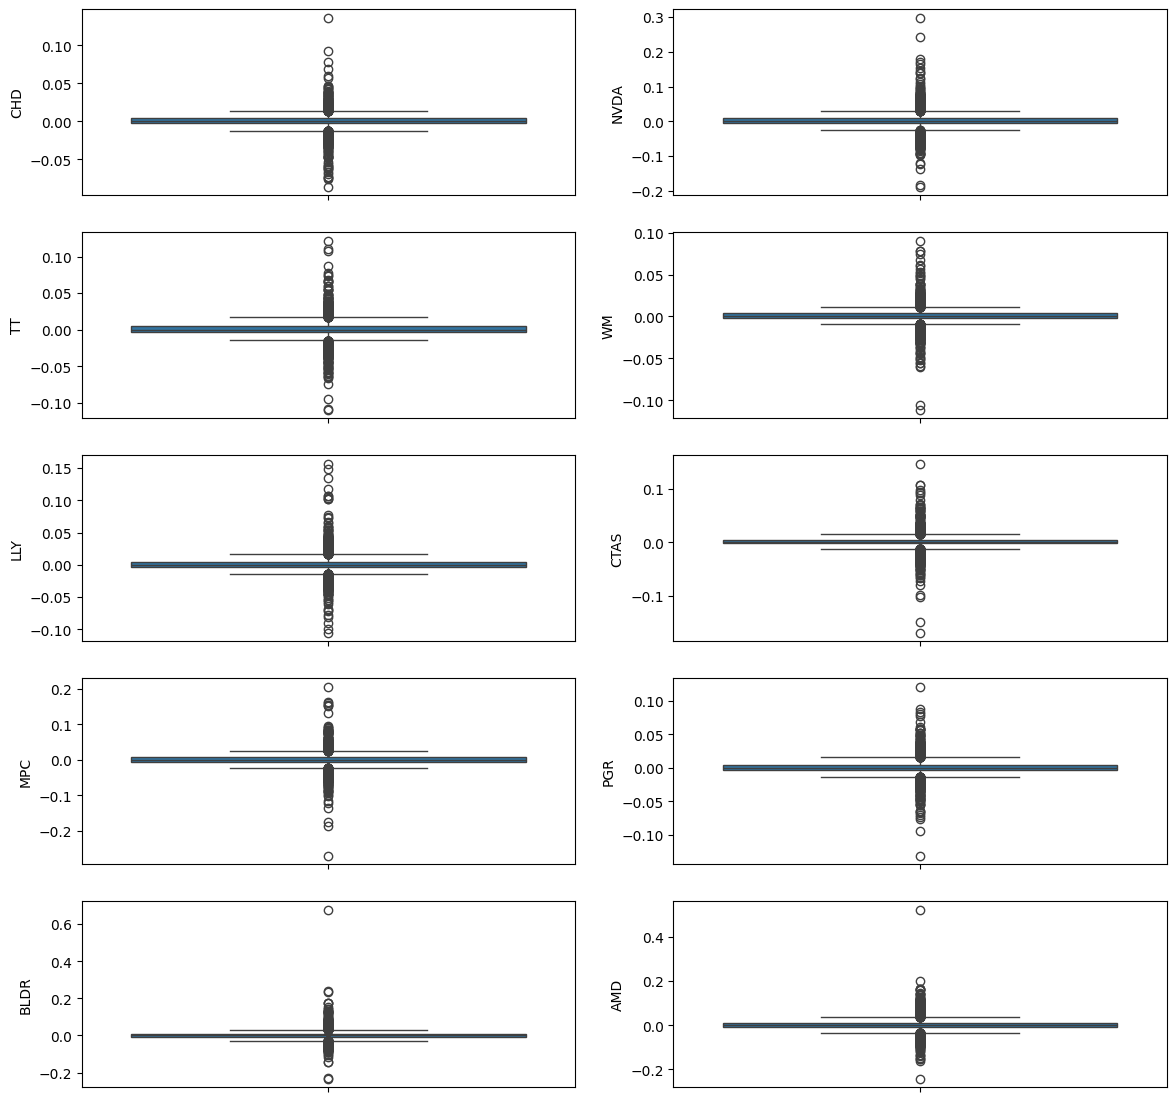

In [451]:
#Voy a graficar mediante un boxplot para identificar más rápido los outliers
import seaborn as sns

plt.figure(figsize=(14,14))#seteo el lienzo
for x,column in zip(range(10),df_rendimientos.columns):
  if x<=10:
      plt.subplot(5,2,x+1)
      sns.boxplot(data=df_rendimientos, y=column)

In [457]:
# Convertir a z score
datos_z=pd.DataFrame()
for j in df_rendimientos.columns:
  datos_z[j] = (df_rendimientos[j] - df_rendimientos[j].mean()) / df_rendimientos[j].std()#z score
datos_z

,CHD,NVDA,TT,WM,LLY,CTAS,MPC,PGR,BLDR,AMD
Date,,,,,,,,,,
2014-03-25,0.411091,-0.071780,0.077086,0.195555,-0.296674,0.279922,0.506696,0.110996,0.694812,-0.048908
2014-03-26,0.097993,-0.998786,-1.892635,-0.284617,0.273622,-0.928654,-0.833274,-0.948323,-2.135278,-0.048908
2014-03-27,-0.266732,-0.613855,-1.103987,0.903907,0.000211,-0.070169,-0.989611,-0.509073,-0.180957,-1.181082
2014-03-28,-0.118440,0.180003,1.048559,0.569105,0.037183,0.295057,0.170756,0.668957,0.272920,-0.300203
2014-03-29,-0.037230,-0.071780,-0.048539,-0.057453,-0.061580,-0.057588,-0.034015,-0.060170,-0.045151,-0.048908
...,...,...,...,...,...,...,...,...,...,...
2024-03-17,-0.037230,-0.071780,-0.048539,-0.057453,-0.061580,-0.057588,-0.034015,-0.060170,-0.045151,-0.048908
2024-03-18,-0.107962,0.214736,0.041330,0.497624,0.737977,-0.342794,-0.121380,0.556133,-0.080349,-0.119193
2024-03-19,0.493703,0.362357,0.764302,0.141107,0.880881,0.263030,0.717263,-0.428011,0.741074,-1.634548


In [458]:
# Iterar sobre cada celda del DataFrame
for i in range(len(datos_z.index)):
    for j in range(len(datos_z.columns)):
        # Verificar si el valor actual es mayor o menor que 2
        if datos_z.iloc[i, j] > 2 or datos_z.iloc[i, j] < -2:
            # Reemplazar el valor por el valor de la celda anterior en la misma columna
            if i > 0:  # Asegurarse de que no estamos en la primera fila
                datos_z.iloc[i, j] = datos_z.iloc[i - 1, j]

In [459]:
datos_z

,CHD,NVDA,TT,WM,LLY,CTAS,MPC,PGR,BLDR,AMD
Date,,,,,,,,,,
2014-03-25,0.411091,-0.071780,0.077086,0.195555,-0.296674,0.279922,0.506696,0.110996,0.694812,-0.048908
2014-03-26,0.097993,-0.998786,-1.892635,-0.284617,0.273622,-0.928654,-0.833274,-0.948323,0.694812,-0.048908
2014-03-27,-0.266732,-0.613855,-1.103987,0.903907,0.000211,-0.070169,-0.989611,-0.509073,-0.180957,-1.181082
2014-03-28,-0.118440,0.180003,1.048559,0.569105,0.037183,0.295057,0.170756,0.668957,0.272920,-0.300203
2014-03-29,-0.037230,-0.071780,-0.048539,-0.057453,-0.061580,-0.057588,-0.034015,-0.060170,-0.045151,-0.048908
...,...,...,...,...,...,...,...,...,...,...
2024-03-17,-0.037230,-0.071780,-0.048539,-0.057453,-0.061580,-0.057588,-0.034015,-0.060170,-0.045151,-0.048908
2024-03-18,-0.107962,0.214736,0.041330,0.497624,0.737977,-0.342794,-0.121380,0.556133,-0.080349,-0.119193
2024-03-19,0.493703,0.362357,0.764302,0.141107,0.880881,0.263030,0.717263,-0.428011,0.741074,-1.634548


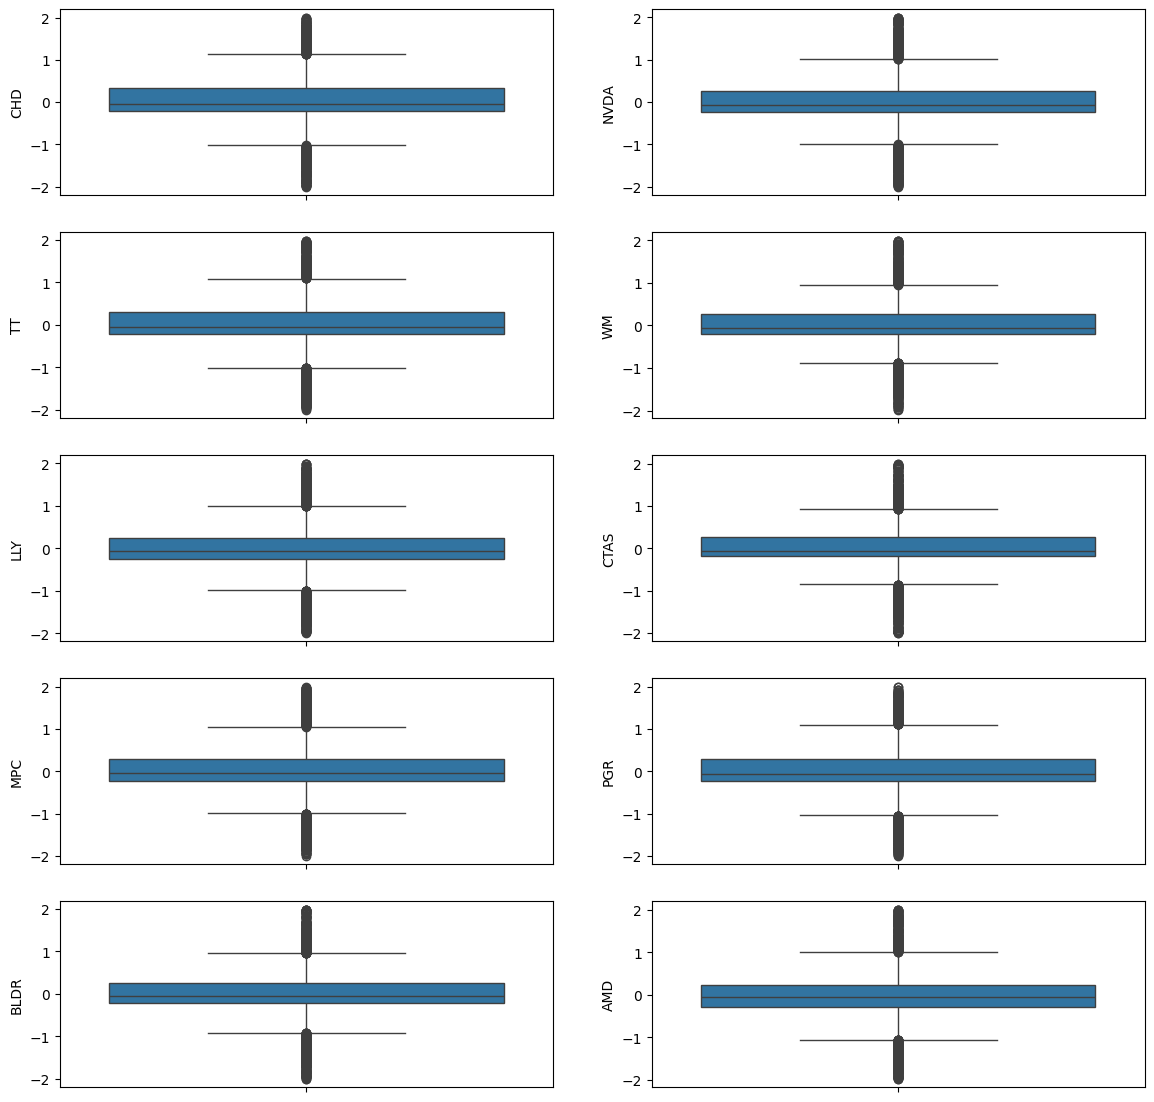

In [460]:
plt.figure(figsize=(14,14))#seteo el lienzo
for x,column in zip(range(10),datos_z.columns):
  if x<=10:
      plt.subplot(5,2,x+1)
      sns.boxplot(data=datos_z, y=column)

ESTACIONALIDAD

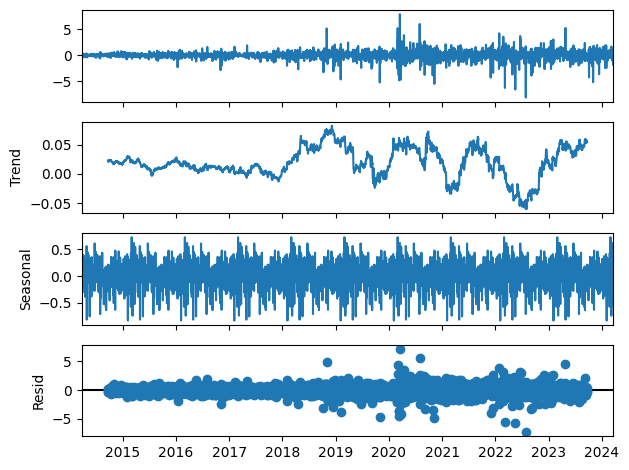

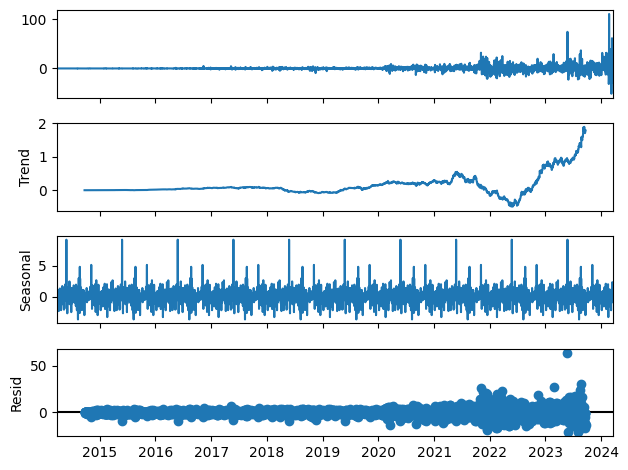

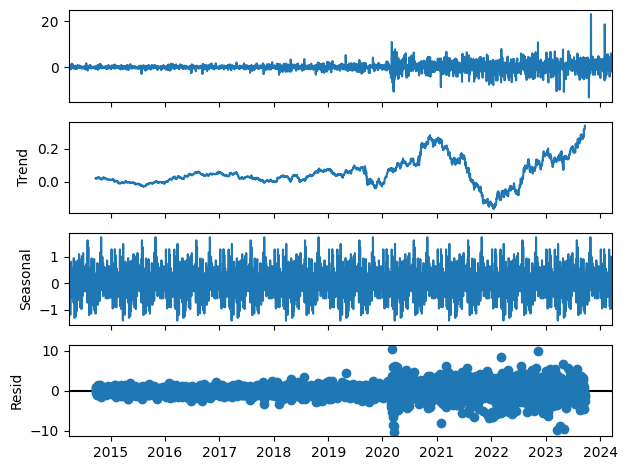

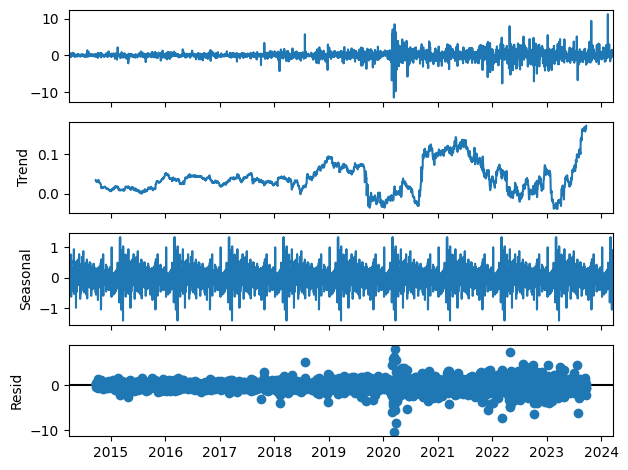

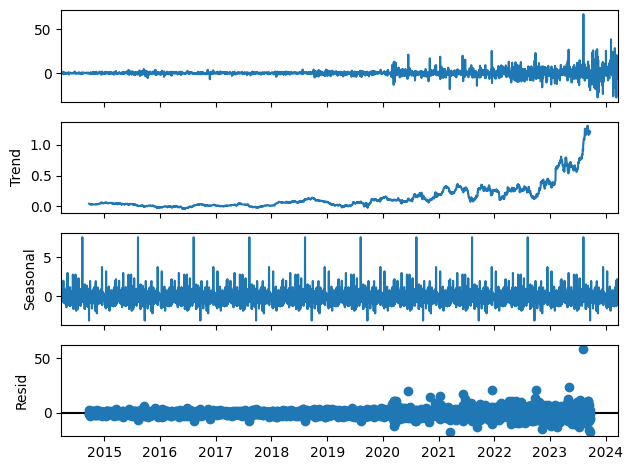

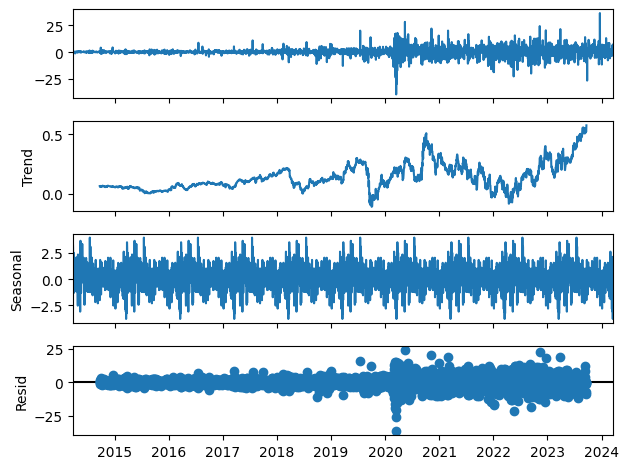

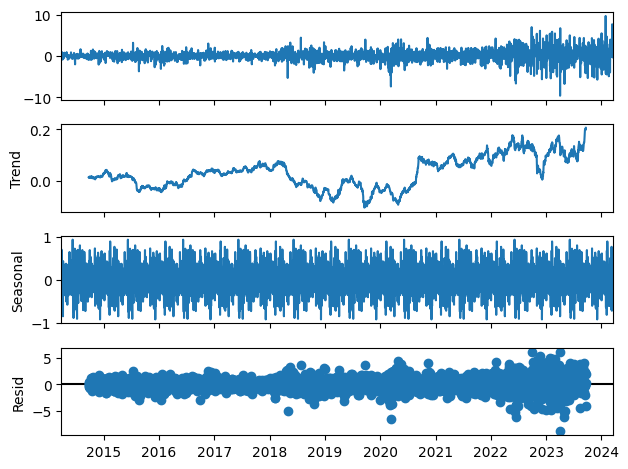

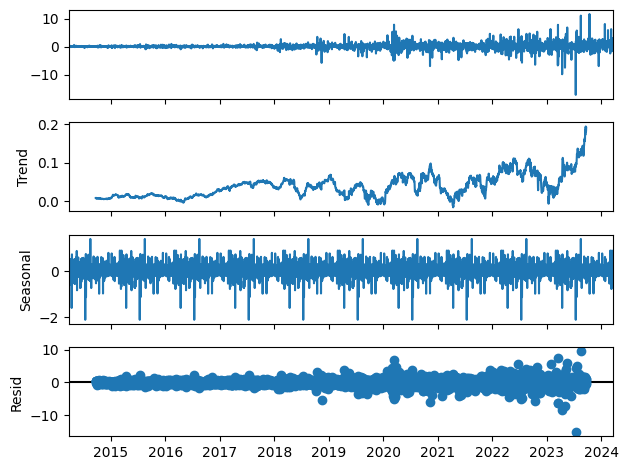

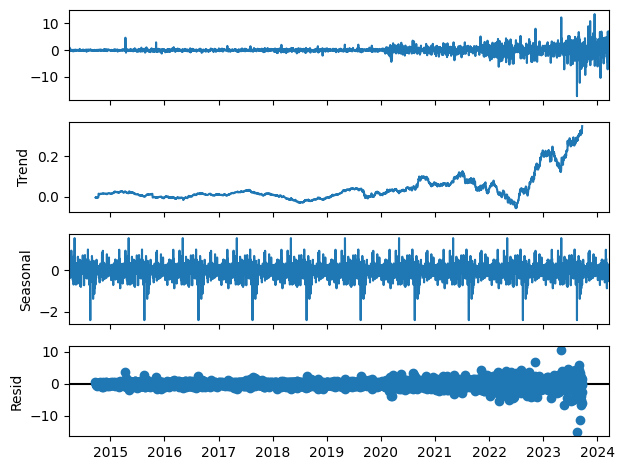

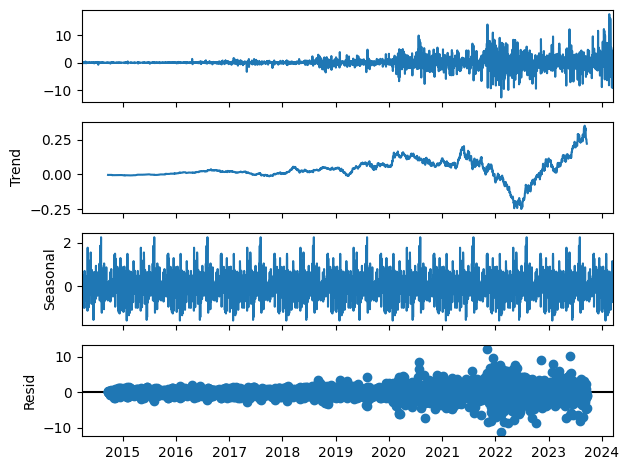

In [443]:
from statsmodels.tsa.seasonal import seasonal_decompose#usamos esta libreria para analizar la estacionalidad
plt.figure()
for i in datos_z.columns:
    result = seasonal_decompose(datos_z[[i]], period=365)
    result.plot();